# In a markdown cell:
"""
# Notebook: Advanced Statistical Arbitrage

## Objective
This notebook serves as a comprehensive research document to build a sophisticated statistical arbitrage strategy. We will move beyond simple pairs trading to explore portfolio-level mean reversion.

Our process will follow three key steps:
1.  **Ingredient 1: Constructing a high-quality mean-reverting asset.** We will use the Johansen test for multivariate cointegration to find stable, multi-asset portfolios from our data.
2.  **Ingredient 2: Modeling the mean-reverting process.** We will perform a deep-dive analysis of the Ornstein-Uhlenbeck (OU) process, focusing on the challenge of robustly estimating its parameters (`mu`, `theta`, `sigma`).
3.  **Ingredient 3: Deriving an optimal trading strategy.** We will investigate the "closed-form" solution from stochastic control theory to calculate optimal trading boundaries directly from the model's parameters.

This notebook will form the foundation for our final, production-ready trading strategy.
"""

In [2]:
# In a code cell:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt
import warnings

# --- Notebook Settings ---
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

# --- Load Data ---
try:
    prices_df = pd.read_csv('prices.txt', header=None, sep=r'\s+')
    print("Price data loaded successfully. Shape:", prices_df.shape)
except FileNotFoundError:
    print("Error: prices.txt not found. Please ensure it's in the correct directory.")
    # Create dummy data if not found, for notebook to run
    prices_df = pd.DataFrame(np.random.randn(750, 50).cumsum(axis=0) + 100)

Price data loaded successfully. Shape: (750, 50)


### **Section 1: Finding The Most Stable Pairs**

In this section, we will return to a foundational approach to find the best possible trading pairs. Instead of the more complex Johansen test, we will use the standard **Engle-Granger two-step method**.

1.  For every possible pair of assets in our dataset, we will calculate the optimal hedge ratio using OLS.
2.  We will then form the "spread" series based on this hedge ratio.
3.  Finally, we will use the **Augmented Dickey-Fuller (ADF) Test** to check if this spread is stationary. A stationary spread is mean-reverting.

We will perform this analysis on the **entire 750-day dataset**. This gives us a complete picture of which pairs were the most stable over the long run.

*(Note: For a real-world backtest, one would typically find pairs on a training set and validate on a test set. Using the full dataset here is an exploratory analysis to find the most robust historical pairs.)*

In [3]:
# In a code cell:

from statsmodels.tsa.stattools import adfuller

def find_adf_coint_pairs(data_df: pd.DataFrame):
    """
    Finds cointegrated pairs by running an OLS regression and testing the
    stationarity of the residuals with the Augmented Dickey-Fuller test.
    
    Args:
        data_df: DataFrame of prices, with assets as columns.
        
    Returns:
        A DataFrame of cointegrated pairs, sorted by the ADF test statistic.
    """
    n_assets = data_df.shape[1]
    coint_pairs = []

    print(f"Testing {n_assets * (n_assets - 1) // 2} unique pairs for cointegration...")
    
    # Iterate over all unique pairs of assets
    for i in range(n_assets):
        for j in range(i + 1, n_assets):
            asset1 = data_df.iloc[:, i]
            asset2 = data_df.iloc[:, j]
            
            # 1. Run OLS regression: asset1 = alpha + beta * asset2
            asset2_with_const = sm.add_constant(asset2)
            model = sm.OLS(asset1, asset2_with_const).fit()
            
            # 2. Get the residuals (the spread)
            spread = model.resid
            
            # 3. Run the ADF test on the spread
            # The null hypothesis of the ADF test is that there is a unit root (the series is non-stationary)
            adf_result = adfuller(spread)
            p_value = adf_result[1]
            adf_statistic = adf_result[0]
            
            # 4. If p-value is low, we reject the null hypothesis and conclude the spread is stationary
            if p_value < 0.05:
                coint_pairs.append({
                    'pair': (i, j),
                    'p_value': p_value,
                    'adf_statistic': adf_statistic
                })

    # Sort the pairs by the most negative ADF statistic (strongest evidence of mean-reversion)
    sorted_pairs_df = pd.DataFrame(coint_pairs).sort_values(by='adf_statistic', ascending=True)
    return sorted_pairs_df

# Run the analysis on the full dataset
coint_pairs_df = find_adf_coint_pairs(prices_df)

print(f"\nAnalysis Complete. Found {len(coint_pairs_df)} cointegrated pairs.")

Testing 1225 unique pairs for cointegration...

Analysis Complete. Found 182 cointegrated pairs.


--- Top Cointegrated Pair ---
Pair: (48, 49)
ADF Statistic: -5.3977
P-value: 0.0000


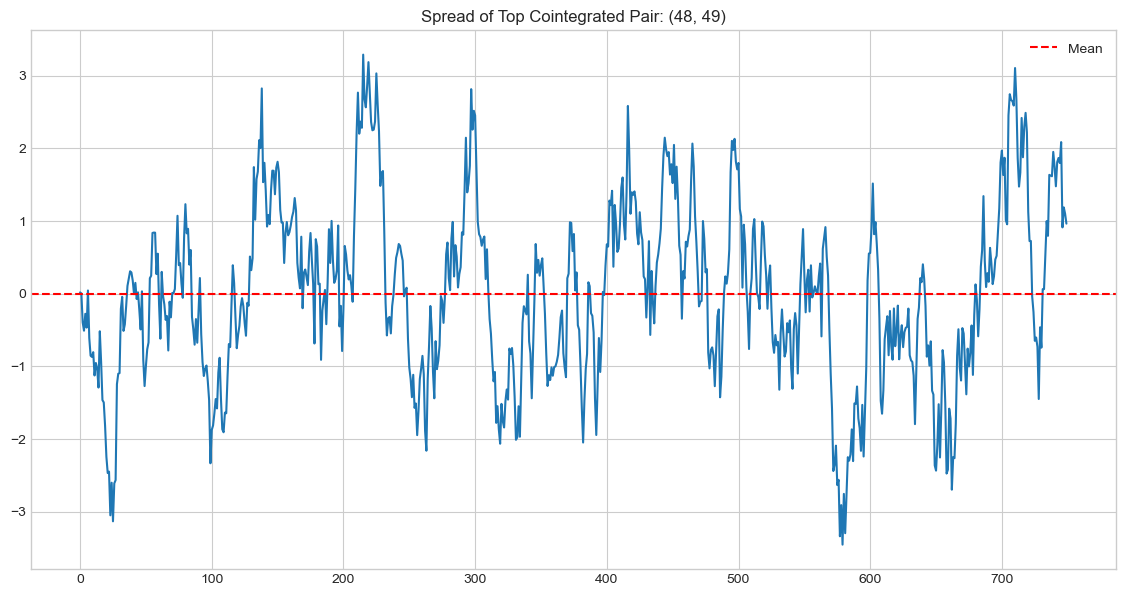

In [4]:
# In a code cell:

if not coint_pairs_df.empty:
    best_pair_info = coint_pairs_df.iloc[0]
    best_pair_indices = best_pair_info['pair']
    
    print("--- Top Cointegrated Pair ---")
    print(f"Pair: {best_pair_indices}")
    print(f"ADF Statistic: {best_pair_info['adf_statistic']:.4f}")
    print(f"P-value: {best_pair_info['p_value']:.4f}")
    
    # Let's plot the spread of this best pair to visually confirm
    asset1 = prices_df.iloc[:, best_pair_indices[0]]
    asset2 = prices_df.iloc[:, best_pair_indices[1]]
    model = sm.OLS(asset1, sm.add_constant(asset2)).fit()
    spread = model.resid
    
    plt.figure(figsize=(14,7))
    spread.plot()
    plt.title(f'Spread of Top Cointegrated Pair: {best_pair_indices}')
    plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
    plt.legend()
    plt.grid(True)
    plt.show()
    
else:
    print("No cointegrated pairs found.")

In [5]:
# In a code cell:

if not coint_pairs_df.empty:
    # Define our dependent (y) and independent (x) variables for the regression
    # We use the full 750 days for this analysis
    y = prices_df.iloc[:, best_pair_indices[0]]
    x = prices_df.iloc[:, best_pair_indices[1]]

    # Add a constant (intercept) to the independent variable.
    x_with_const = sm.add_constant(x)

    # --- 1. Standard OLS ---
    print("\n--- 1. Ordinary Least Squares (OLS) ---")
    model_ols = sm.OLS(y, x_with_const).fit()
    
    # --- THIS IS THE FIX ---
    # We use .iloc[1] to explicitly access the second element (the hedge ratio) by its position.
    hedge_ratio_ols = model_ols.params.iloc[1]
    print(f"Hedge Ratio (beta): {hedge_ratio_ols:.4f}")
    # --- END OF FIX ---
    
    print("\nOLS Model Summary:")
    print(model_ols.summary())

    # --- 2. OLS with HAC (Newey-West) Standard Errors ---
    # This corrects the standard errors, t-stats, and p-values to be more reliable.
    print("\n\n--- 2. OLS with HAC (Newey-West) Standard Errors ---")
    model_hac = sm.OLS(y, x_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
    
    # --- APPLYING THE SAME FIX HERE ---
    hedge_ratio_hac = model_hac.params.iloc[1]
    print(f"Hedge Ratio (beta): {hedge_ratio_hac:.4f} (Same as OLS)")
    # --- END OF FIX ---
    
    print("\nHAC Model Summary:")
    print(model_hac.summary())
    
else:
    print("Skipping deep dive as no pairs were found.")


--- 1. Ordinary Least Squares (OLS) ---
Hedge Ratio (beta): 0.8615

OLS Model Summary:
                            OLS Regression Results                            
Dep. Variable:                     48   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     1343.
Date:                Mon, 30 Jun 2025   Prob (F-statistic):          3.95e-169
Time:                        01:30:25   Log-Likelihood:                -1211.8
No. Observations:                 750   AIC:                             2428.
Df Residuals:                     748   BIC:                             2437.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

# In a markdown cell:
"""
### 2.1 Deep Dive: The Challenge of Estimating OU Parameters

Now that we have a high-quality, mean-reverting portfolio, we need to model its behavior. The standard stochastic model for this is the **Ornstein-Uhlenbeck (OU) process**, defined by `dX = θ(μ - X)dt + σdW`.

The critical challenge is that the parameters (`μ`, `θ`, `σ`) are not truly constant. They can change over time. If we estimate them using a rolling window of data, we can see how unstable these estimates can be. This is a major source of **model risk**.

Let's investigate this by plotting the rolling estimates of `theta` (reversion speed) and `mu` (the mean).
"""

--- Analyzing OU Parameter Stability using a 100-day rolling window ---


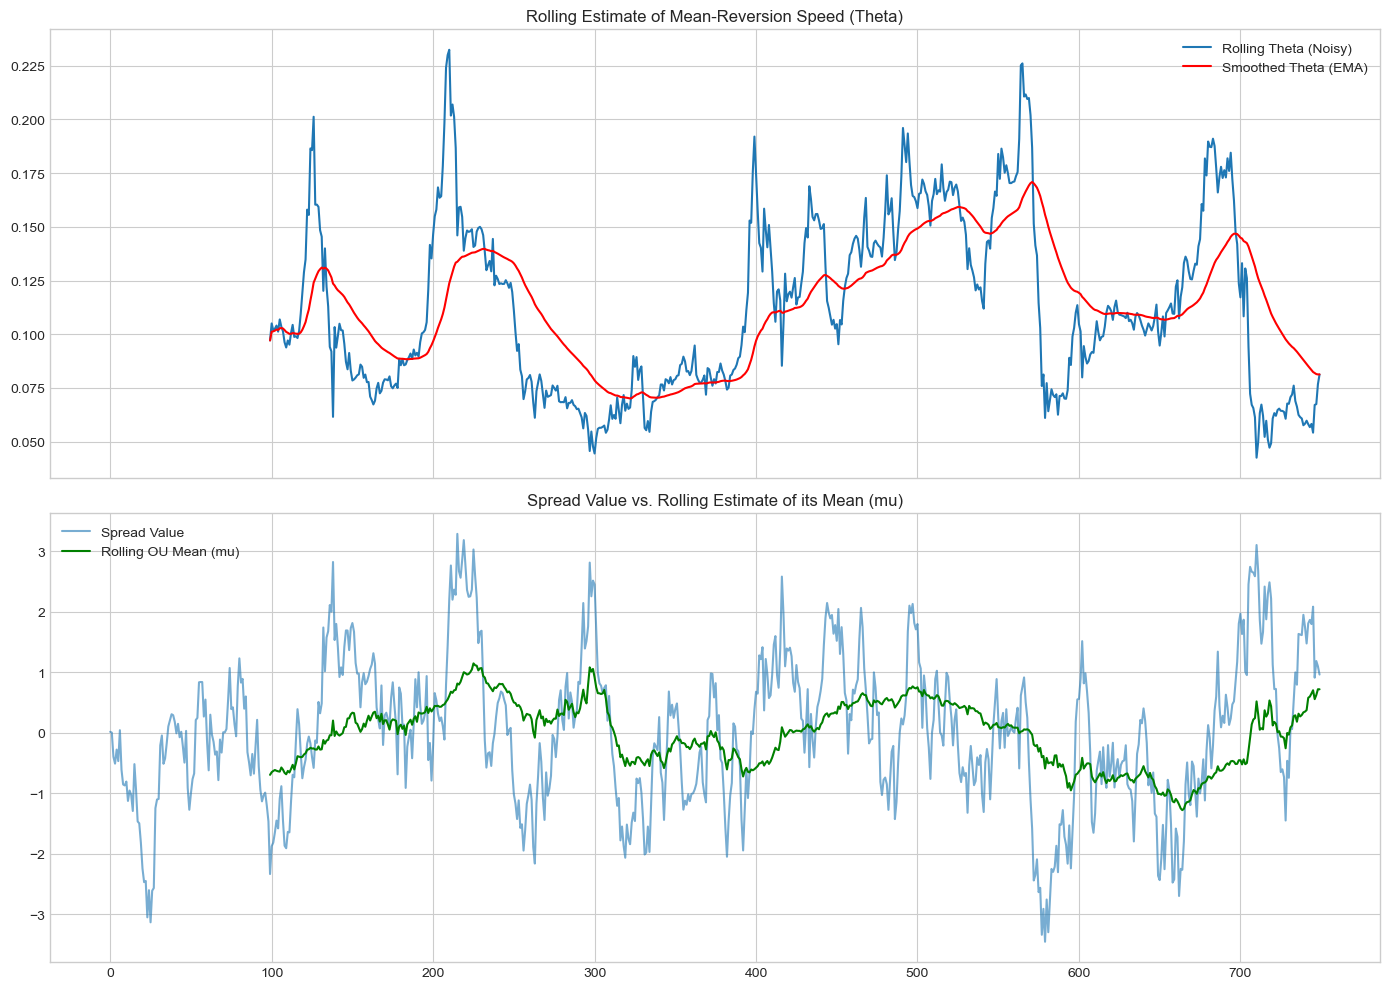

In [6]:
# In a code cell:
def estimate_ou_parameters(spread_series: np.ndarray):
    """Estimates OU parameters for a given spread series."""
    # This helper function remains the same.
    if len(spread_series) < 2: return None
    spread_lagged = spread_series[:-1]
    spread_diff = spread_series[1:] - spread_lagged
    x_reg = sm.add_constant(spread_lagged)
    model = sm.OLS(spread_diff, x_reg).fit()
    alpha, beta = model.params
    if beta >= 0: return None # Not mean-reverting if beta is positive
    
    # Calculate OU parameters from regression coefficients
    theta = -np.log(1 + beta)
    mu = alpha / theta
    sigma_ou = np.std(model.resid) / np.sqrt(-2 * np.log(1 + beta))
    
    return {'mu': mu, 'theta': theta, 'sigma_ou': sigma_ou}

# We check if the 'spread' variable was successfully created in the previous cell.
if 'spread' in locals() and not spread.empty:
    LOOKBACK = 100 # Lookback window for the rolling parameter estimation
    
    print(f"--- Analyzing OU Parameter Stability using a {LOOKBACK}-day rolling window ---")
    
    # --- THIS IS THE FIX ---
    # We replace the .apply() method with an explicit loop to avoid the TypeError.
    rolling_params_list = []
    # Create the rolling window object
    rolling_window = spread.rolling(window=LOOKBACK)
    
    # Manually iterate through each window provided by the object
    for window in rolling_window:
        # The first few windows will be smaller than the lookback, so we skip them
        if len(window) < LOOKBACK:
            continue
        
        params = estimate_ou_parameters(window.to_numpy())
        
        # Add the calculated parameters and the end-date of the window to our list
        if params:
            # The index for this calculation is the last day of the window
            params['timestamp'] = window.index[-1]
            rolling_params_list.append(params)
    
    # Convert the list of dictionaries into a clean DataFrame
    if rolling_params_list:
        rolling_params_df = pd.DataFrame(rolling_params_list).set_index('timestamp')
    # --- END OF FIX ---

        # --- Plotting the results ---
        fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
        
        # Plot 1: Rolling Theta (Reversion Speed)
        axes[0].plot(rolling_params_df['theta'], label='Rolling Theta (Noisy)')
        rolling_params_df['theta'].ewm(span=60).mean().plot(ax=axes[0], color='r', label='Smoothed Theta (EMA)')
        axes[0].set_title('Rolling Estimate of Mean-Reversion Speed (Theta)')
        axes[0].legend()
        
        # Plot 2: Rolling Mu (Mean) vs. the actual spread
        axes[1].plot(spread, label='Spread Value', alpha=0.6)
        axes[1].plot(rolling_params_df['mu'], color='g', label='Rolling OU Mean (mu)')
        axes[1].set_title('Spread Value vs. Rolling Estimate of its Mean (mu)')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()
    else:
        print("Could not estimate OU parameters on a rolling basis.")
else:
    print("Skipping parameter analysis as no cointegrated pair was found in the previous step.")

# In a markdown cell:
"""
### 3.1 The Stochastic Control "Closed-Form" Solution

Your friend's hint about a "closed-form solution" refers to using **Stochastic Control Theory** (and the Hamilton-Jacobi-Bellman equation) to derive the optimal trading strategy directly, rather than finding it with a brute-force grid search.

The solution gives us optimal entry and exit boundaries as a function of our model parameters. The formula we'll use is a standard simplification:
* **Optimal Entry Boundary = `f(reversion_speed, volatility, risk_aversion, costs)`**
* **Optimal Exit Boundary = `g(costs)`**

A key insight is that a faster-reverting (`high theta`) and less volatile (`low sigma`) spread is a better opportunity, which should lead to tighter trading boundaries.
"""


--- Plotting Optimal Trading Boundaries ---


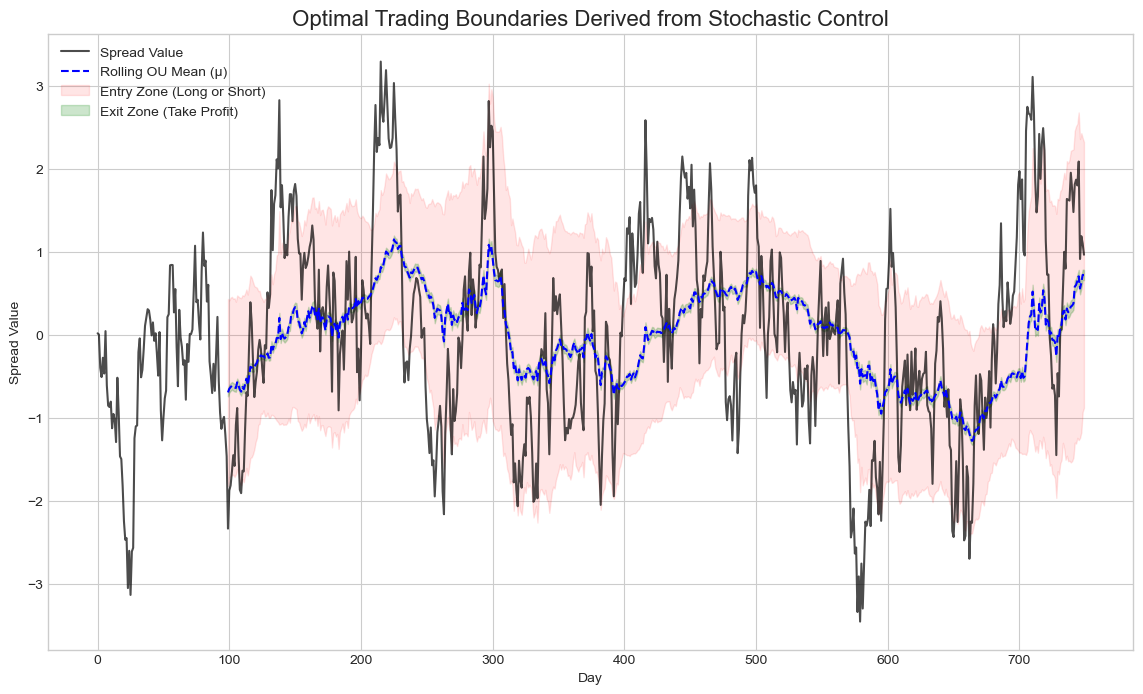

In [7]:
# In a code cell:

def calculate_optimal_boundaries(theta, sigma_ou, risk_aversion, transaction_cost):
    """Calculates the optimal entry and exit boundaries using a closed-form solution."""
    # This helper function remains the same.
    if theta <= 0 or sigma_ou <= 0: return None
    
    # This term represents the desired profit, balancing reversion speed against volatility and risk
    profit_target = (sigma_ou / np.sqrt(2 * theta)) * risk_aversion
    
    # The optimal entry threshold is the target profit plus transaction costs
    entry_boundary = profit_target + transaction_cost * sigma_ou
    
    # The optimal exit is when the spread reverts back past the transaction cost band
    exit_boundary = transaction_cost * sigma_ou
    
    return {'entry': entry_boundary, 'exit': exit_boundary}

# We check if 'rolling_params_df' was successfully created in the previous cell.
if 'rolling_params_df' in locals() and not rolling_params_df.empty:
    
    # Use the SMOOTHED theta for a more stable boundary calculation
    rolling_params_df['theta_smoothed'] = rolling_params_df['theta'].ewm(span=60).mean()
    
    # Calculate the optimal boundaries for each day
    boundaries = rolling_params_df.apply(
        lambda row: calculate_optimal_boundaries(
            row['theta_smoothed'], 
            row['sigma_ou'], 
            risk_aversion=0.5,      # This is a key hyperparameter you can tune
            transaction_cost=0.05   # Assumed cost as a fraction of volatility
        ),
        axis=1
    )
    
    # Clean up the results
    boundaries = boundaries.dropna()
    boundaries_df = pd.DataFrame(boundaries.tolist(), index=boundaries.index)
    
    # Join the boundaries with the parameter data for plotting
    plot_df = rolling_params_df.join(boundaries_df)
    
    # Calculate the upper and lower bands for our plot
    plot_df['upper_entry'] = plot_df['mu'] + plot_df['entry']
    plot_df['lower_entry'] = plot_df['mu'] - plot_df['entry']
    plot_df['upper_exit'] = plot_df['mu'] + plot_df['exit']
    plot_df['lower_exit'] = plot_df['mu'] - plot_df['exit']
    
    # --- Plotting ---
    print("\n--- Plotting Optimal Trading Boundaries ---")
    plt.figure(figsize=(14, 8))
    
    # --- MODIFICATION ---
    # We now plot the 'spread' of our best pair, not a 'portfolio_series'.
    spread.plot(label='Spread Value', color='black', alpha=0.7)
    # --- END MODIFICATION ---

    plot_df['mu'].plot(label='Rolling OU Mean (μ)', color='blue', linestyle='--')
    
    # Use fill_between to show the trading zones
    plt.fill_between(plot_df.index, plot_df['lower_entry'], plot_df['upper_entry'], color='red', alpha=0.1, label='Entry Zone (Long or Short)')
    plt.fill_between(plot_df.index, plot_df['lower_exit'], plot_df['upper_exit'], color='green', alpha=0.2, label='Exit Zone (Take Profit)')
    
    plt.title('Optimal Trading Boundaries Derived from Stochastic Control', fontsize=16)
    plt.xlabel('Day')
    plt.ylabel('Spread Value')
    plt.legend()
    plt.show()

else:
    print("Skipping boundary analysis as rolling OU parameters were not calculated.")

In [8]:
# In a code cell:

# This checks if the coint_pairs_df from our earlier ADF test exists.
if 'coint_pairs_df' in locals() and not coint_pairs_df.empty:
    
    print(f"--- Verifying all {len(coint_pairs_df)} cointegrated pairs for OU model suitability ---")
    
    verified_pairs = []
    
    # Loop through each cointegrated pair we found
    for index, row in coint_pairs_df.iterrows():
        pair = row['pair']
        asset1_idx, asset2_idx = pair
        
        # 1. Re-calculate the OLS spread for this pair
        asset1 = prices_df.iloc[:, asset1_idx]
        asset2 = prices_df.iloc[:, asset2_idx]
        model = sm.OLS(asset1, sm.add_constant(asset2)).fit()
        spread = model.resid
        hedge_ratio = model.params.iloc[1]
        
        # 2. Estimate the OU parameters for its spread
        ou_params = estimate_ou_parameters(spread.to_numpy())
        
        # 3. We only keep the pair if the OU estimation was successful AND theta > 0.
        if ou_params and ou_params['theta'] > 0:
            verified_pairs.append({
                'pair': pair,
                'hedge_ratio': hedge_ratio,
                'adf_statistic': row['adf_statistic'],
                'ou_theta': ou_params['theta'], # Speed of reversion
                'ou_mu': ou_params['mu'],         # Long-term mean
                'ou_sigma': ou_params['sigma_ou'] # Volatility
            })
            
    # --- Final Report Generation ---
    if verified_pairs:
        # Create a DataFrame of all valid, mean-reverting pairs
        verified_df = pd.DataFrame(verified_pairs)
        
        # --- NEW: FILTERING LOGIC ---
        print("\n--- Filtering for the Optimal Non-Overlapping Portfolio ---")
        
        # 1. Sort all valid pairs by theta (descending). The best pairs are now at the top.
        sorted_by_theta_df = verified_df.sort_values(by='ou_theta', ascending=False)
        
        # 2. Greedily select the best non-overlapping pairs
        final_portfolio_pairs = []
        used_assets = set()
        
        for index, row in sorted_by_theta_df.iterrows():
            asset1, asset2 = row['pair']
            
            # If neither asset in the pair has been used yet...
            if asset1 not in used_assets and asset2 not in used_assets:
                # ...add this pair to our final portfolio...
                final_portfolio_pairs.append(row)
                # ...and mark both assets as used.
                used_assets.add(asset1)
                used_assets.add(asset2)
        
        # Create the final DataFrame for display
        final_portfolio_df = pd.DataFrame(final_portfolio_pairs).reset_index(drop=True)
        # --- END OF NEW LOGIC ---
        
        print("\n\n--- Analysis Complete ---")
        print(f"Found {len(final_portfolio_df)} optimal, non-overlapping pairs, ranked by reversion speed.")
        
        print("\n--- FINAL OPTIMIZED PORTFOLIO OF TRADABLE PAIRS ---")
        print(final_portfolio_df.to_string())
    else:
        print("\n\n--- Verification Complete ---")
        print("No pairs passed the final OU model suitability check.")

else:
    print("Cannot run verification as no initial cointegrated pairs were found.")

--- Verifying all 182 cointegrated pairs for OU model suitability ---

--- Filtering for the Optimal Non-Overlapping Portfolio ---


--- Analysis Complete ---
Found 16 optimal, non-overlapping pairs, ranked by reversion speed.

--- FINAL OPTIMIZED PORTFOLIO OF TRADABLE PAIRS ---
        pair  hedge_ratio  adf_statistic  ou_theta     ou_mu  ou_sigma
0   (48, 49)     0.861531      -5.397706  0.078496  0.014858  1.174868
1    (8, 34)    -0.478832      -4.653509  0.057479 -0.026248  1.651243
2   (11, 23)     0.488072      -4.095336  0.041468 -0.102420  2.867692
3    (2, 22)    -0.701530      -3.463226  0.040509 -0.138424  3.555342
4   (18, 30)     0.393543      -4.000562  0.036941  0.149544  1.662855
5   (29, 42)     0.965483      -3.683713  0.036824  0.068413  2.264555
6    (9, 31)     1.878606      -3.225134  0.030912 -1.037511  5.806138
7    (7, 13)     1.295080      -3.582569  0.030341  0.188426  2.853011
8   (25, 37)     0.825191      -3.140736  0.028851 -0.320412  2.614138
9    (3, 4